In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

N.B.: I recommend that you use the `statsmodel` library to do the regression analysis as opposed to *e.g.* `sklearn`. The `sklearn` library is great for advanced topics, but it's easier to get lost in a sea of details and it's not needed for these problems.

## Body Mass Index Model

In this problem, you will first clean a data set and create a model to estimate body fat based on the common BMI measure. Then, you will use the **forward stepwise selection** and **backware stepwise selection** methods to create more accurate predictors for body fat.

The body density dataset in file `bodyfat` includes the following 15 variables listed from left to right:
* Density : Density determined from underwater weighing
* Fat : Percent body fat from Siri’s (1956) equation
* Age : Age (years)
* Weight : Weight (kg)
* Height : Height (cm)
* Neck : Neck circumference (cm)
* Chest: Chest circumference (cm)
* Abdomen : Abdomen circumference (cm)
* Hip : Hip circumference (cm)
* Thigh : Thigh circumference (cm)
* Knee : Knee circumference (cm)
* Ankle : Ankle circumference (cm)
* Biceps : Biceps (extended) circumference (cm)
* Forearm : Forearm circumference (cm)
* Wrist : Wrist circumference (cm)

The `Density` column is the "gold standard" -- it is a measure of body density obtained by dunking people in water and measuring the displacement. The `Fat` column is a prediction using another statistical model. The body mass index (BMI) is [calculated as Kg/m^2](https://en.wikipedia.org/wiki/Body_mass_index) and is used to classify people into different weight categories with a [BMI over 30 being 'obese'](https://www.medicalnewstoday.com/info/obesity). You will find that BMI is a poor predictor of the `Density` information it purports to predict. You will try to find better models using measurements and regression.

Unfortunately for us, the dataset we have has imperial units for weight and height, so we will convert those to metric and then calculate the BMI and plot the KDE of the data.

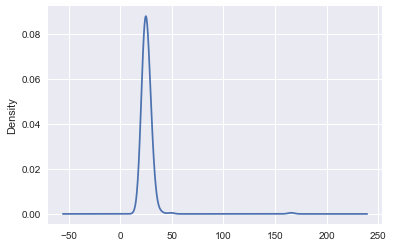

In [13]:
fat = pd.read_csv('bodyfat.csv')
fat = fat.drop('Unnamed: 0', axis=1)
fat.Weight = fat.Weight * 0.453592 # Convert to Kg
fat.Height = fat.Height * 0.0254 # convert inches to m
fat['BMI'] = fat.Weight / (fat.Height**2)
fat.BMI.plot.kde();

### a.
The BMI has at least one outlier since it's unlikely anyone has a BMI of 165, even [Arnold Schwarzenegger](http://www.health.com/health/gallery/0,,20460621,00.html).

Form a new table `cfat` (cleaned fat) that removes any rows with a BMI greater than 40 and calculate the regression model predicting the `Density` from the `BMI`. Display the summary of the regression model. You should achieve an $R^2$ of at least 0.53.

In [14]:
### BEGIN SOLUTION
cfat = fat.drop(fat[fat.BMI > 40].index)
bmi = smf.ols(formula='Density ~ BMI', data=cfat).fit()
bmi.summary()
### END SOLUTION

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Density   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     286.2
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           3.25e-43
Time:                        12:48:09   Log-Likelihood:                 734.17
No. Observations:                 250   AIC:                            -1464.
Df Residuals:                     248   BIC:                            -1457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1602      0.006    186.410      0.000       1.148       1.172
BMI           -0.0041      0.000    -16.918      0.000      -0.005      -0.004
==============================================================================
Omnibus:                        2.262   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.259
Skew:                           0.229   Prob(JB):                        0.323
Kurtosis:                       2.916   Cond. No.                         195.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### b. 
Plot your regression model against the BMI measurement, properly labeling the scatterplot axes and showing the regression line. In subsequent models, you will not be able to plot the Density *vs* your predictors because you will have too many predictors, but it's useful to visually understand the relationship between the BMI predictor and the `Density` because you should find that the regression line goes through the data but there is too much variability in the data to achieve a good $R^2$.

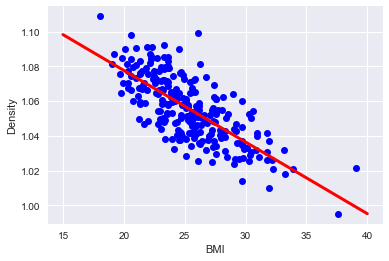

In [15]:
### BEGIN SOLUTION
plt.plot(cfat.BMI, cfat.Density, 'bo')
xticks = np.linspace(15,40)
plt.plot(xticks, bmi.params[0] + xticks * bmi.params[1], 'r', lw=3)
plt.xlabel('BMI')
plt.ylabel('Density');
### END SOLUTION

## Constructing Better Predictors for Bodyfat

 The `BMI` model uses easy-to-measure predictors, but has a poor $R^2 \sim 0.54$. We will use structured subset selection methods from ISLR Chapter 6.1 to derive two better predictors. That chapter covers *best subset*, *forward stepwise* and *backware stepwise* selection. I have implemented the *best subset* selection which searches across all combinations of $1, 2, \ldots, p$ predictors and selects the best predictor based on the $\textit{adjusted}~R^2$ metric. This method involved analyzing $2^{13} = 8192$ regression models (programming and computers for the win). The resulting $\textit{adjusted}~R^2$ plot is shown below:
 
 <img src='fat-best-rsqadj.png'>
 
In this plot, `test_fat` and `train_fat` datasets each containing 200 randomly selected samples were derived from the `cfat` dataset using `np.random.choice` over the `cfat.index` and selected using the Pandas `loc` method. Then, following the algorithm of ISLR Algorithm 6.1 *Best Subset Selection*, all $p \choose k$ models with $k$ predictors were evaluated on the training data and the model returning the best $\textit{Adjusted}~R^2$ was selected. These models are indicated by the data points for the solid blue line. As the text indicates, other measures (AIC, BIC, $C_p$) would be better than the $\textit{Adjusted}~R^2$, but we use it becuase because you've already seen the $R^2$ and should have an understanding of what it means.

Then, the best models for each $k$ were evaluated for the `test_fat` data. These results are shown as the red dots below the blue line. Note that because the test and train datasets are randomly selected subsets, the results vary from run-to-run and it may that your test data produces better $R^2$ than your training data.

This splitting of the data into a test and train set is similar to the *validation set approach* that you can read about in Chapter 5 of ISLR if you choose, but differs in that the two sets may contain duplicate data. The chief reason to use a test and training set is to drill into your skull the limitation of models on unseen data.

In the following exercises, you can not use the `Density`, `Fat` or `BMI` columns in your predictive models. You can only use the 13 predictors in the `allowed_factors` list.

In [16]:
allowed_factors = ['Age', 'Weight', 'Height', 'Neck', 'Chest',
       'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm',
       'Wrist']

## Forward Stepwise Refinement

You will manuall perform the steps of the *forward stepwise selection* method for four parameters. You will do this following Algorithm 6.2 from ISLR. For $k = 1\ldots 4$:
* Set up a regression model with $k$ factors that involves the fixed predictors from the previous step $k-1$
* Try all $p$ predictors in the new $k$th position
* Select the best parameter using $\textit{Adjusted}-R^2$ (e.g. `model.rsquared_adj`) given your training data
* Fix the new parameter and continue the process for $k+1$

Then, you will construct a plot similar to the one above, plotting the $\textit{Adjusted}-R^2$ for each of your $k$ steps and plotting the $\textit{Adjusted}-R^2$ from the test set using that model.

### c. 
First, construct your training and test sets. These should each contain 200 (possibly duplicated) samples from your `cfat` dataset:

In [17]:
### BEGIN SOLUTION
train_fat = cfat.loc[np.random.choice(cfat.index, 200)]
test_fat = cfat.loc[np.random.choice(cfat.index, 200)]
### END SOLUTION

### d. Conduct the algorithm above for $k=1$, leaving your best solution as the answer

In [18]:
### BEGIN SOLUTION
train_bmi1 = smf.ols(formula='Density ~ Abdomen', data=train_fat).fit()
train_bmi1.rsquared_adj
### END SOLUTION

0.56617806692542305

### e. Conduct the algorithm above for $k=2$, leaving your best solution as the answer 

In [19]:
### BEGIN SOLUTION
train_bmi2 = smf.ols(formula='Density ~ Abdomen+Weight', data=train_fat).fit()
train_bmi2.rsquared_adj
### END SOLUTION

0.61633293459361904

### f. Conduct the algorithm above for $k=3$, leaving your best solution as the answer 

In [20]:
### BEGIN SOLUTION
train_bmi3 = smf.ols(formula='Density ~ Abdomen+Weight+Wrist', data=train_fat).fit()
train_bmi3.rsquared_adj
### END SOLUTION

0.62414228417669448

### g. Conduct the algorithm above for $k=4$, leaving your best solution as the answer

In [21]:
### BEGIN SOLUTION
train_bmi4 = smf.ols(formula='Density ~ Abdomen+Weight+Wrist+Biceps', data=train_fat).fit()
train_bmi4.rsquared_adj
### END SOLUTION

0.6353039060348955

### h. Conduct the algorithm above for $k=5$, leaving your best solution as the answer 

In [22]:
### BEGIN SOLUTION
train_bmi5 = smf.ols(formula='Density ~ Abdomen+Weight+Wrist+Biceps+Age', data=train_fat).fit()
train_bmi5.rsquared_adj
### END SOLUTION

0.63377000217578749

### i. Plot

Plot your resulting $\textit{adjusted}~R^2$ *vs* number of predictors and overlay the $\textit{adjusted}~R^2$ for the test data.

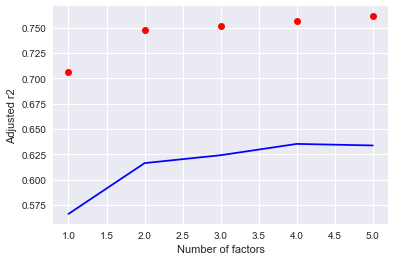

In [23]:
### BEGIN SOLUTION
xs = [1,2,3,4,5]
ys = [train_bmi1.rsquared_adj, train_bmi2.rsquared_adj, train_bmi3.rsquared_adj, 
      train_bmi4.rsquared_adj, train_bmi5.rsquared_adj]

ys2 = [smf.ols(formula='Density ~ Abdomen', data=test_fat).fit().rsquared_adj,
    smf.ols(formula='Density ~ Abdomen+Weight', data=test_fat).fit().rsquared_adj,
    smf.ols(formula='Density ~ Abdomen+Weight+Wrist', data=test_fat).fit().rsquared_adj,
    smf.ols(formula='Density ~ Abdomen+Weight+Wrist+Biceps', data=test_fat).fit().rsquared_adj,
    smf.ols(formula='Density ~ Abdomen+Weight+Wrist+Biceps+Age', data=test_fat).fit().rsquared_adj,
]

plt.plot(xs, ys, 'b')
plt.plot(xs,ys2, 'ro')
plt.xlabel('Number of factors')
plt.ylabel('Adjusted r2');
### END SOLUTION

### j. Discussion

The BMI model has the benefit being simple (two measurements, height and wright). Looking at your resulting regression model, how many parameters would you suggest to use for your enhanced BMI model? Justify your answer using your models.

In [ ]:
### BEGIN SOLUTION
#I would use $k=3$ parameters because that is a large increase in $R^2$ up ot that point. Beyond that, the small increase in $R^2$ doesn't appear worth the extra measurements.
### END SOLUTION